In [1]:
!pip install tensorflow-addons


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import warnings
import tensorflow_addons as tfa
warnings.filterwarnings('ignore')

## Read datasets and labels

In [3]:
df = pd.read_csv("./attack_dataset.csv") # attack dataset
attack_classes = pd.read_csv("./attack_labels.csv") # labels
bonafide = pd.read_csv('./bonafide_dataset_20191121.csv.gz') # bonafide dataset
print(df.shape, bonafide.shape)

(86480, 41) (103094, 41)


### Attack labels

In [4]:
attack_classes['label'].unique()

array(['nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null', 'nmap_tcp_xmas',
       'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn', 'nmap_ping_scan', 'nmap_vvv', 'nmap_connect',
       'nmap_fast', 'nmap_servinfo', 'nmap_reason', 'nmap_open',
       'nmap_top10', 'nmap_fragv', 'nmap_mtu', 'nmap_spoof_idle',
       'nmap_decoy', 'nmap_noping', 'nmap_udping', 'nmap_ack_syn',
       'nmap_syn', 'nmap_ipproto', 'nmap_udp', 'nmap_null', 'nmap_fin',
       'nmap_stealth', 'nmap_spoof_mac', 'nmap_fake_srcprt',
       'nmap_data_length', 'nmap_bad_checksum', 'nmap_random_host',
       'nmap_iflist', 'nmap_fw_bypass', 'nmap_firewalk',
       'nmap_http

### Create **attack dataset** with labels defined by  *ip_src*

In [5]:
df_labeled = df.merge(attack_classes, how='inner', left_on='ip.src', right_on='ip')
df_labeled.drop(['ip'], axis=1, inplace=True)
df_labeled.head(2)

,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,ip.tos,...,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
0,1,"Dec 31, 1969 21:03:41.953641000 -03",221.953641,20,58,58,0x00000800,4,20,NaN,...,0,0,0,0,0,1024,0x00005cb1,0,1460.0,nmap_tcp_syn
1,1,"Dec 31, 1969 21:03:41.953762000 -03",221.953762,21,58,58,0x00000800,4,20,NaN,...,0,0,0,0,0,1024,0x00007d1e,0,1460.0,nmap_tcp_syn


In [6]:
bonafide['label'] = "bonafide" # create column label on bonafide dataset

## Comparing _bonafide_ and _attack_ datasets
> Check if both dataset have the same columns/features/attributes and calculate the balance (%) of bonafide and attack packets

In [7]:
if (df_labeled.columns == bonafide.columns).all():
    examples_attack = df_labeled.shape[0]
    examples_bonafide = bonafide.shape[0]
    total = examples_attack+examples_bonafide
    print('Total examples of {0} with {1:0.2f} of attack and {2:0.2f} bonafide packets'.format(total, examples_attack/total, examples_bonafide/total))

Total examples of 140163 with 0.26 of attack and 0.74 bonafide packets


## Pre-processing
> Required to convert features that were extracted from `pcap` as hexadecimal
> Filled the values with NaN with Zero

In [8]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df_labeled[field] = df_labeled[field].apply(lambda x: int(str(x), 16))

In [9]:
bonafide = bonafide.fillna(0)
for field in fields:
    bonafide[field] = bonafide[field].apply(lambda x: int(str(x), 16))

### Create AB-TRAP dataset with all packets (bonafide and attack)

In [10]:
full_data = pd.concat([bonafide, df_labeled])

### Check if there are packets with the protocol field different than TCP (value 6)

In [11]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("It was found and removed", wrong_proto,"packets.")

It was found and removed [11708] packets.


### Features not applicable to this study

> Remove features from link layer - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remove features that are redundant or invariable
> - ip.version - we consider only IPv4
> - ip.proto - this study is applicable only to TCP
> - ip.src - this attribute is removed to allow the generalization of learning (not learn past attackers)
> - ip.dst - this attribute is removed to allow the generalization of learning (not learn past targets)
> - ip.flags - this is removed because we use bit-set of flags
> - tcp.flags - this is removed because we use bit-set of flags

In [12]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True)

## Exploratory Data Analysis

In [13]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128455 entries, 1 to 37068
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           128455 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                128455 non-null  int64  
 3   ip.flags.rb          128455 non-null  float64
 4   ip.flags.df          128455 non-null  float64
 5   ip.flags.mf          128455 non-null  float64
 6   ip.frag_offset       128455 non-null  float64
 7   ip.ttl               128455 non-null  float64
 8   ip.checksum          128455 non-null  int64  
 9   ip.len               128455 non-null  float64
 10  ip.dsfield           128455 non-null  int64  
 11  tcp.srcport          128455 non-null  float64
 12  tcp.dstport          128455 non-null  float64
 13  tcp.seq              128455 non-null  float64
 14  tcp.ack              128455 non-null  float64
 15  tcp.len           

In [14]:
full_data.describe()

,ip.hdr_len,ip.tos,ip.id,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.checksum,ip.len,...,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val
count,128455.0,91386.0,128455.000000,128455.0,128455.000000,128455.0,128455.000000,128455.000000,128455.000000,128455.000000,...,128455.000000,128455.000000,128455.000000,128455.000000,128455.000000,128455.000000,1.284550e+05,128455.000000,128455.000000,115134.000000
mean,20.0,0.0,31527.863213,0.0,0.563388,0.0,0.086209,117.020287,32240.725328,562.270780,...,0.387435,0.019991,0.083850,0.548449,0.031365,0.008509,8.907874e+03,32449.793539,0.678744,359.404329
std,0.0,0.0,19605.220369,0.0,0.495968,0.0,0.406187,85.963373,19031.578341,676.602078,...,0.487166,0.139971,0.277164,0.497649,0.174303,0.091850,7.518775e+04,19183.397913,171.836116,636.972162
min,20.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000,1.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,20.0,0.0,14285.000000,0.0,0.000000,0.0,0.000000,56.000000,15366.500000,40.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.430000e+02,15436.500000,0.000000,0.000000
50%,20.0,0.0,31282.000000,0.0,1.000000,0.0,0.000000,62.000000,31893.000000,52.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.024000e+03,32507.000000,0.000000,0.000000
75%,20.0,0.0,48886.000000,0.0,1.000000,0.0,0.000000,242.000000,48786.000000,1426.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.024000e+03,48897.000000,0.000000,0.000000
max,20.0,0.0,65535.000000,0.0,1.000000,0.0,2.000000,254.000000,65534.000000,5981.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.644544e+07,65533.000000,46335.000000,8961.000000


In [15]:
# check features with zero variance (not useful for learning)
(full_data.var() == 0)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf             True
ip.frag_offset         False
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool

In [16]:
# remove columns with zero variance
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Univariate features analysis (boxplot)

In [17]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

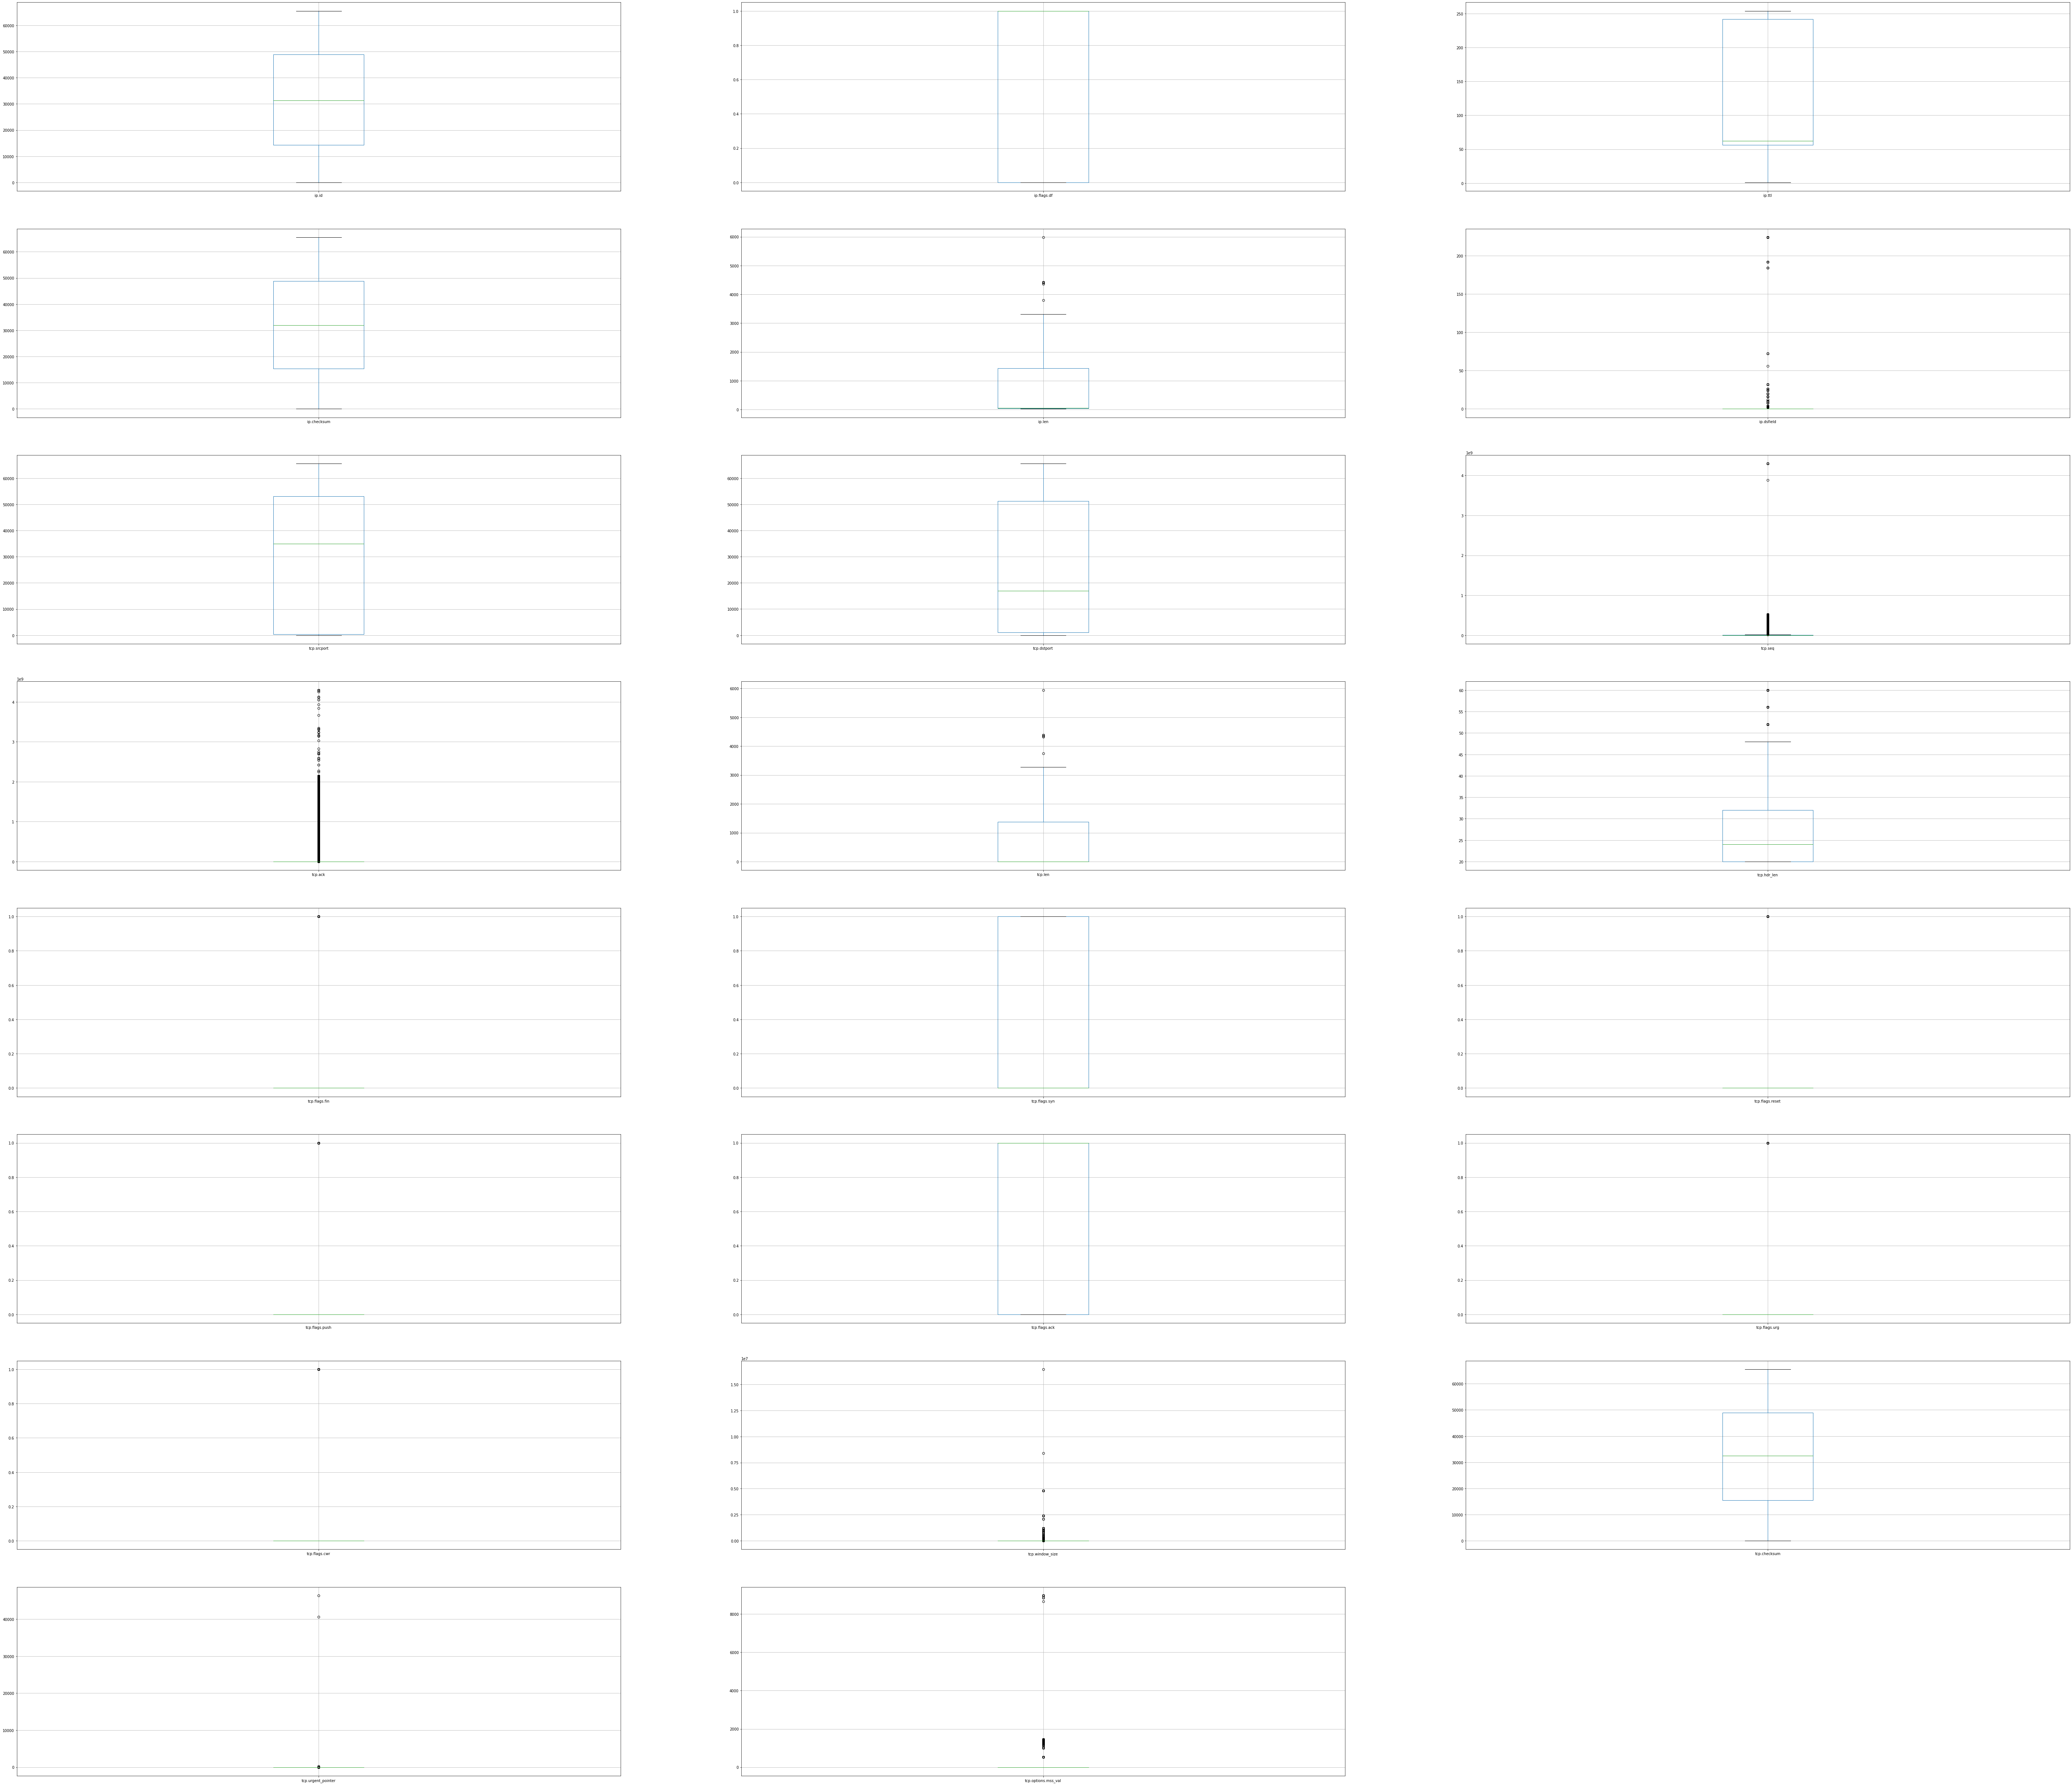

In [18]:
_columns = 3
lines = int(full_data.shape[1]/_columns)+1

plt.figure(figsize = [100, 100])

i = 1
for column in full_data.columns.values:
    if column != "label":
        plt.subplot(lines, _columns, i)
        full_data.boxplot([column]);
        i += 1

### Bivariate Analysis - Linear correlation (absolute threshold of 0.5)

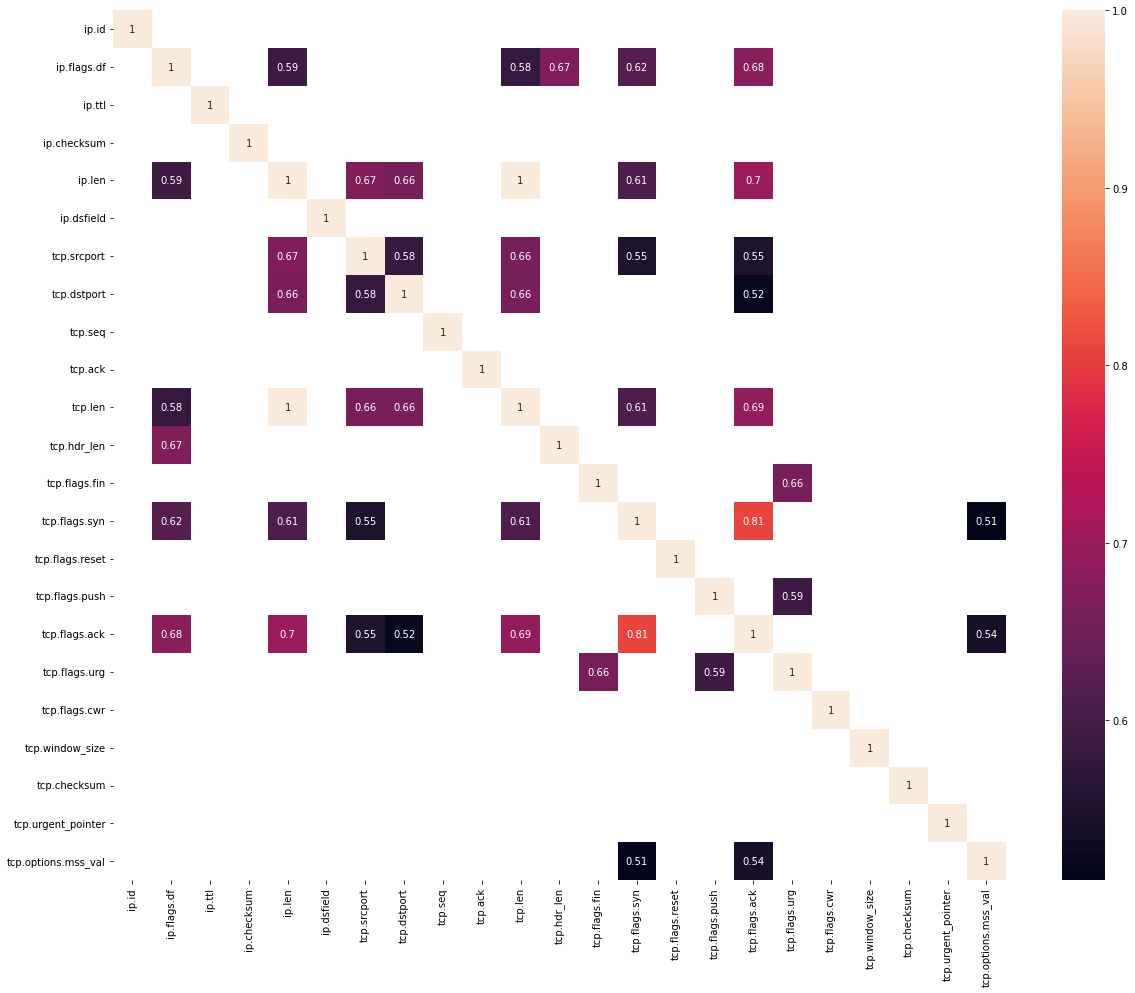

In [19]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Machine Learning - Binary Classification _(attack x bonafide)_

In [20]:
full_data['label'].value_counts()

bonafide                 91386
nmap_servinfo             2016
nmap_connect              2008
nmap_mtu                  2006
nmap_open                 2006
nmap_reason               2006
nmap_vvv                  2002
nmap_spoof_idle           1417
zmap_tcp_syn              1250
unicornscan_tcp_conn      1026
unicornscan_tcp_syn       1017
unicornscan_tcp_null      1014
unicornscan_tcp_xmas      1014
unicornscan_tcp_fxmas     1014
unicornscan_tcp_fin       1014
unicornscan_tcp_ack       1014
nmap_fragv                1003
masscan_tcp_syn           1003
nmap_tcp_conn             1002
hping_tcp_syn             1001
nmap_tcp_fin              1001
nmap_tcp_syn              1001
nmap_tcp_null             1001
nmap_tcp_xmas             1001
nmap_tcp_maimon           1000
nmap_tcp_ack              1000
nmap_tcp_window           1000
hping_tcp_fin             1000
hping_tcp_xmas            1000
hping_tcp_null            1000
hping_tcp_ack             1000
nmap_fast                  206
nmap_top

In [21]:
full_data.label[full_data.label == "bonafide"] = 0 # convert bonafide label to 0
full_data.label[full_data.label != 0] = 1 # convert attack labels to 1
full_data['label'].value_counts()

0    91386
1    37069
Name: label, dtype: int64

In [22]:
full_data.shape

(128455, 24)

In [23]:
# It is removed ttl because previous attempt shows that it is learning the LAN architecture TTL=62
# (from scan tools TTL=64 minus 2 routers in the infrastructure)

# sequence, checksum and acknowledge features because they are random

# removed source and destination ports to be agnostic regarding the service ports

# removed tcp.options.mss_val because it is dificult to be retrieved as LKM

# removed tcp.window_size to allow running iperf on ESP32 and to reduce false positives

full_data.drop(columns=["ip.checksum", "ip.ttl", "tcp.checksum", "tcp.dstport", "tcp.seq", "tcp.srcport", 
                        "tcp.ack", "tcp.options.mss_val", "tcp.window_size"], axis=1, inplace=True)

In [24]:
full_data

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.urgent_pointer,label
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37064,19724,0.0,28.0,0,0.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
37065,15843,0.0,28.0,0,0.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
37066,55863,0.0,28.0,0,0.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
37067,41278,0.0,28.0,0,0.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [25]:
from sklearn.tree import DecisionTreeClassifier

algorithms = {
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(128455, 14) (128455,)


In [26]:
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.urgent_pointer
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X = X.astype(int) 
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.urgent_pointer
1,46834,0,40,0,0,20,0,1,0,0,0,0,0,0
3,3793,1,537,8,485,32,0,0,0,1,1,0,0,0
4,0,1,80,0,0,60,0,0,0,0,1,0,0,0
5,8559,1,54,0,2,32,0,0,0,1,1,0,0,0
6,54321,0,40,8,0,20,0,1,0,0,0,0,0,0


## Grid Search

In [28]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # can be used roc_auc_score for binary classification

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(X.iloc[train], y.iloc[train])
        score[algorithm].append(perf(best.predict(X.iloc[test]), y.iloc[test]))

DT


In [29]:
# f1-scores
pd.DataFrame.from_dict(score)

,DT
0,0.934986
1,0.939454
2,0.934301
3,0.940588
4,0.937442
5,0.934823
6,0.932457
7,0.937253
8,0.933683
9,0.935458


## Results from Grid Search
> For conjunction of parameters, mean and std deviation

In [30]:
table = {
    'class_weight': [x['class_weight'] for x in best.cv_results_['params']],
    'criterion': [x['criterion'] for x in best.cv_results_['params']],
    'max_depth': [x['max_depth'] for x in best.cv_results_['params']],
    'mean_test_score': best.cv_results_['mean_test_score'],
    'std_test_score': best.cv_results_['std_test_score']
}
dados = []
for i in range(0,len(best.cv_results_['params'])):
    dados.append([best.cv_results_['params'][i]['criterion'], 
                  best.cv_results_['params'][i]['max_depth'], best.cv_results_['mean_test_score'][i]])
pd.DataFrame.from_dict(table).head(15)

,class_weight,criterion,max_depth,mean_test_score,std_test_score
0,None,gini,1,0.000000,0.000000
1,None,gini,2,0.651701,0.002808
2,None,gini,3,0.832995,0.002339
3,None,gini,4,0.910205,0.002044
4,None,gini,5,0.913181,0.002296
5,None,gini,6,0.920202,0.001833
6,None,gini,7,0.922086,0.002218
7,None,gini,8,0.935891,0.001702
8,None,gini,9,0.936055,0.001794
9,None,gini,10,0.935776,0.001641


In [31]:
gini = {}
entropia = {}
for valores in dados:
    if valores[0] == "gini":
        gini.update({valores[1] : valores[2]})
    else:
        entropia.update({valores[1] : valores[2]})

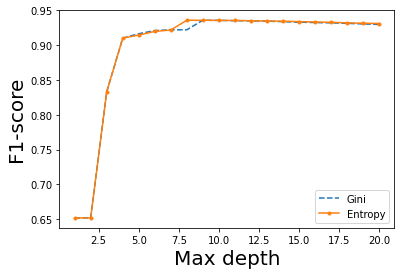

In [32]:
lists1 = sorted(gini.items())
lists2 = sorted(entropia.items())
x_gini, y_gini = zip(*lists1)
x_entropia, y_entropia = zip(*lists2)

plt.ylabel('F1-score', fontsize=20)
plt.xlabel('Max depth', fontsize=20)
plt.plot(x_gini, y_gini, '--', label='Gini')
plt.plot(x_entropia, y_entropia, '.-', label='Entropy')
plt.legend(loc="lower right");

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [34]:
dt10 = DecisionTreeClassifier(criterion="entropy", max_depth=10, class_weight=None)
dt12 = DecisionTreeClassifier(criterion="entropy", max_depth=12, class_weight=None)

dt10.fit(x_train, y_train)
dt12.fit(x_train, y_train)
dt10_pred = dt10.predict(x_test)
dt12_pred = dt12.predict(x_test)
print(f1_score(y_test, dt10_pred))
print(f1_score(y_test, dt12_pred))

0.9377555057365158
0.9368976897689768


In [35]:
BinaryF1Score = tfa.metrics.F1Score(num_classes=2)
F1Score = lambda y_true, y_pred: BinaryF1Score(tf.one_hot(tf.cast(y_true, tf.int32), 2), y_pred)
print(F1Score(y_train, tf.one_hot(tf.cast(y_train, tf.int32), 2)))
hidden_size = x_train.shape[1] + 2
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_size, activation=tf.nn.sigmoid, input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(hidden_size, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tfa.metrics.F1Score(num_classes=2)])
model.summary()

2022-08-12 09:31:25.972122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 09:31:26.009062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-12 09:31:26.009079: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-12 09:31:26.009473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

tf.Tensor([1. 1.], shape=(2,), dtype=float32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 546
Trainable params: 546
Non-trainable params: 0
_________________________________________________________________


In [36]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,tf.one_hot(tf.cast(y_train, tf.int32), 2))).batch(256)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, tf.one_hot(tf.cast(y_val, tf.int32), 2))).batch(1024)

In [37]:
history = model.fit(train_ds, validation_data=val_ds, epochs=2000)

Epoch 1/2000
322/322 [==============================] - 1s 2ms/step - loss: 0.6061 - f1_score: 0.4157 - val_loss: 0.6048 - val_f1_score: 0.4157
Epoch 2/2000
322/322 [==============================] - 0s 1ms/step - loss: 0.6035 - f1_score: 0.4157 - val_loss: 0.6028 - val_f1_score: 0.4157
Epoch 3/2000
322/322 [==============================] - 0s 2ms/step - loss: 0.6019 - f1_score: 0.4157 - val_loss: 0.6014 - val_f1_score: 0.4157
Epoch 4/2000
322/322 [==============================] - 0s 1ms/step - loss: 0.6008 - f1_score: 0.4157 - val_loss: 0.6005 - val_f1_score: 0.4157
Epoch 5/2000
322/322 [==============================] - 0s 2ms/step - loss: 0.6000 - f1_score: 0.4157 - val_loss: 0.5997 - val_f1_score: 0.4157
Epoch 6/2000
322/322 [==============================] - 0s 1ms/step - loss: 0.5993 - f1_score: 0.4157 - val_loss: 0.5991 - val_f1_score: 0.4157
Epoch 7/2000
322/322 [==============================] - 0s 1ms/step - loss: 0.5987 - f1_score: 0.4157 - val_loss: 0.5984 - val_f1_score:

In [38]:
mlp_pred = tf.argmax(model.predict(x_test), axis=-1)
print(f1_score(y_test, mlp_pred))

803/803 [==============================] - 1s 637us/step
0.9133774834437087


In [39]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)
mlp_pred = (lr.predict(x_test) >= 0.5).astype(np.int32)
print(f1_score(y_test, mlp_pred))

0.5576907216494845
